In [1]:
!pip install astro-datasets numpy matplotlib albumentations adapt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb

2022-12-21 05:18:45.736687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'IllustrisTNG', 'field': 'T', 
                                                 'parameters': ['omegam']})

2022-12-21 05:19:04.052121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 05:19:07.932522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78977 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:84:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'SIMBA', 'field': 'T', 
                                                 'parameters': ['omegam']})

In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_train = simba_train.repeat(count=3) # increase dataset size
simba_train = simba_train.map(process_data)
simba_train = simba_train.map(set_shapes)
simba_train = simba_train.map(normalize)
simba_train = simba_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_val = simba_val.map(normalize)
simba_val = simba_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
#design CNN architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64*H),
  tf.keras.layers.LeakyReLU(0.2), 
  tf.keras.layers.Dropout(0.2),  
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 14)      140       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 14)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 14)      1778      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 14)     56        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 14)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 14)      798       
                                                        

 leaky_re_lu_17 (LeakyReLU)  (None, 4, 4, 448)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 1, 1, 896)         6423424   
                                                                 
 batch_normalization_17 (Bat  (None, 1, 1, 896)        3584      
 chNormalization)                                                
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 1, 1, 896)         0         
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dropout (Dropout)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 448)               401856    
                                                                 
 leaky_re_

In [11]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [12]:
#compile model, set the optimiser and the loss as defined above 
model.compile(optimizer=opt,
              loss='mae',
              metrics=['mse'])

In [13]:
epochs = 50

In [14]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

In [15]:




model.fit(cmd_train, epochs=epochs, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), reduce_lr, cp_callback], 
          validation_data=cmd_val)

Epoch 1/75


2022-12-20 15:40:50.345894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-20 15:41:01.298534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-20 15:41:01.316299: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f446c0135b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-20 15:41:01.316575: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-12-20 15:41:01.348384: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-20 15:41:02.372295: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

317/317 [==============================] - ETA: 0s - loss: 0.2769 - mse: 0.6165
Epoch 1: val_loss improved from inf to 0.33211, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 446s 1s/step - loss: 0.2769 - mse: 0.6165 - val_loss: 0.3321 - val_mse: 0.1313 - lr: 0.0010
Epoch 2/75
317/317 [==============================] - ETA: 0s - loss: 0.0987 - mse: 0.0624
Epoch 2: val_loss improved from 0.33211 to 0.17564, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 340s 1s/step - loss: 0.0987 - mse: 0.0624 - val_loss: 0.1756 - val_mse: 0.0428 - lr: 0.0010
Epoch 3/75
317/317 [==============================] - ETA: 0s - loss: 0.0632 - mse: 0.0283
Epoch 3: val_loss did not improve from 0.17564
317/317 [==============================] - 288s 907ms/step - loss: 0.0632 - mse: 0.0283 - val_loss: 0.3976 - val_mse: 0.1911 - lr: 0.0010
Epoch 4/75
317/317 [==============================] - ETA: 0s - loss: 0.0504 - mse: 0.0146
Epoch 4: val_loss did not improve from 0.17564
317/317 [==============================] - 288s 906ms/step - loss: 0.0504 - mse: 0.0146 - val_loss: 11.5608 - val_mse: 137.7899 - lr: 0.0010
Epoch 5/75
317/317 [==============================] - ETA: 0s - loss: 0.0403 - mse: 0.0083
Epoch 5: val_loss did not improve from 0.17564
317/317 [==============================] - 289s 912ms/step - loss: 0.0403 - mse: 0.0083 - val_loss: 0.2555 - val_mse: 0.1162 - lr: 0.0010
Epoch 6/75
317/317 [==============

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 340s 1s/step - loss: 0.0343 - mse: 0.0048 - val_loss: 0.1280 - val_mse: 0.0230 - lr: 0.0010
Epoch 7/75
317/317 [==============================] - ETA: 0s - loss: 0.0322 - mse: 0.0032
Epoch 7: val_loss did not improve from 0.12799
317/317 [==============================] - 293s 923ms/step - loss: 0.0322 - mse: 0.0032 - val_loss: 0.4166 - val_mse: 0.2310 - lr: 0.0010
Epoch 8/75
317/317 [==============================] - ETA: 0s - loss: 0.0305 - mse: 0.0029
Epoch 8: val_loss improved from 0.12799 to 0.08897, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 339s 1s/step - loss: 0.0305 - mse: 0.0029 - val_loss: 0.0890 - val_mse: 0.0102 - lr: 0.0010
Epoch 9/75
317/317 [==============================] - ETA: 0s - loss: 0.0285 - mse: 0.0024
Epoch 9: val_loss did not improve from 0.08897
317/317 [==============================] - 283s 894ms/step - loss: 0.0285 - mse: 0.0024 - val_loss: 1.2754 - val_mse: 5.6500 - lr: 0.0010
Epoch 10/75
317/317 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0020
Epoch 10: val_loss did not improve from 0.08897
317/317 [==============================] - 288s 908ms/step - loss: 0.0289 - mse: 0.0020 - val_loss: 0.1702 - val_mse: 0.1227 - lr: 0.0010
Epoch 11/75
317/317 [==============================] - ETA: 0s - loss: 0.0275 - mse: 0.0020
Epoch 11: val_loss did not improve from 0.08897
317/317 [==============================] - 289s 912ms/step - loss: 0.0275 - mse: 0.0020 - val_loss: 4.3834 - val_mse: 26.4169 - lr: 0.0010
Epoch 12/75
317/317 [===========

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 337s 1s/step - loss: 0.0264 - mse: 0.0019 - val_loss: 0.0719 - val_mse: 0.0077 - lr: 0.0010
Epoch 16/75
317/317 [==============================] - ETA: 0s - loss: 0.0260 - mse: 0.0020
Epoch 16: val_loss did not improve from 0.07193
317/317 [==============================] - 288s 909ms/step - loss: 0.0260 - mse: 0.0020 - val_loss: 0.3931 - val_mse: 0.4737 - lr: 0.0010
Epoch 17/75
317/317 [==============================] - ETA: 0s - loss: 0.0252 - mse: 0.0019
Epoch 17: val_loss did not improve from 0.07193
317/317 [==============================] - 287s 906ms/step - loss: 0.0252 - mse: 0.0019 - val_loss: 1.6223 - val_mse: 5.1432 - lr: 0.0010
Epoch 18/75
317/317 [==============================] - ETA: 0s - loss: 0.0259 - mse: 0.0021
Epoch 18: val_loss improved from 0.07193 to 0.06555, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 341s 1s/step - loss: 0.0259 - mse: 0.0021 - val_loss: 0.0655 - val_mse: 0.0070 - lr: 0.0010
Epoch 19/75
317/317 [==============================] - ETA: 0s - loss: 0.0250 - mse: 0.0019
Epoch 19: val_loss did not improve from 0.06555
317/317 [==============================] - 291s 917ms/step - loss: 0.0250 - mse: 0.0019 - val_loss: 0.3297 - val_mse: 0.1453 - lr: 0.0010
Epoch 20/75
317/317 [==============================] - ETA: 0s - loss: 0.0248 - mse: 0.0017
Epoch 20: val_loss did not improve from 0.06555
317/317 [==============================] - 290s 915ms/step - loss: 0.0248 - mse: 0.0017 - val_loss: 0.0914 - val_mse: 0.0121 - lr: 0.0010
Epoch 21/75
317/317 [==============================] - ETA: 0s - loss: 0.0246 - mse: 0.0018
Epoch 21: val_loss did not improve from 0.06555
317/317 [==============================] - 289s 911ms/step - loss: 0.0246 - mse: 0.0018 - val_loss: 0.0809 - val_mse: 0.0098 - lr: 0.0010
Epoch 22/75
317/317 [==========

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 337s 1s/step - loss: 0.0178 - mse: 6.6801e-04 - val_loss: 0.0459 - val_mse: 0.0030 - lr: 3.0000e-04
Epoch 30/75
317/317 [==============================] - ETA: 0s - loss: 0.0172 - mse: 6.1534e-04
Epoch 30: val_loss improved from 0.04588 to 0.04440, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 344s 1s/step - loss: 0.0172 - mse: 6.1534e-04 - val_loss: 0.0444 - val_mse: 0.0029 - lr: 3.0000e-04
Epoch 31/75
317/317 [==============================] - ETA: 0s - loss: 0.0170 - mse: 5.9973e-04
Epoch 31: val_loss improved from 0.04440 to 0.04186, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 337s 1s/step - loss: 0.0170 - mse: 5.9973e-04 - val_loss: 0.0419 - val_mse: 0.0030 - lr: 3.0000e-04
Epoch 32/75
317/317 [==============================] - ETA: 0s - loss: 0.0168 - mse: 5.9038e-04
Epoch 32: val_loss did not improve from 0.04186
317/317 [==============================] - 290s 913ms/step - loss: 0.0168 - mse: 5.9038e-04 - val_loss: 0.1033 - val_mse: 0.0161 - lr: 3.0000e-04
Epoch 33/75
317/317 [==============================] - ETA: 0s - loss: 0.0168 - mse: 5.8773e-04
Epoch 33: val_loss did not improve from 0.04186
317/317 [==============================] - 289s 912ms/step - loss: 0.0168 - mse: 5.8773e-04 - val_loss: 0.0595 - val_mse: 0.0064 - lr: 3.0000e-04
Epoch 34/75
317/317 [==============================] - ETA: 0s - loss: 0.0166 - mse: 5.8235e-04
Epoch 34: val_loss did not improve from 0.04186
317/317 [==============================] - 288s 909ms/step - loss: 0.0166 - mse: 5.8235e-04 - val_loss: 0.0574 - val_mse: 0.0048 - lr

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 336s 1s/step - loss: 0.0137 - mse: 3.7963e-04 - val_loss: 0.0206 - val_mse: 8.0008e-04 - lr: 9.0000e-05
Epoch 43/75
317/317 [==============================] - ETA: 0s - loss: 0.0134 - mse: 3.6096e-04
Epoch 43: val_loss did not improve from 0.02060
317/317 [==============================] - 289s 911ms/step - loss: 0.0134 - mse: 3.6096e-04 - val_loss: 0.0230 - val_mse: 9.2530e-04 - lr: 9.0000e-05
Epoch 44/75
317/317 [==============================] - ETA: 0s - loss: 0.0132 - mse: 3.5093e-04
Epoch 44: val_loss improved from 0.02060 to 0.01339, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 336s 1s/step - loss: 0.0132 - mse: 3.5093e-04 - val_loss: 0.0134 - val_mse: 3.6535e-04 - lr: 9.0000e-05
Epoch 45/75
317/317 [==============================] - ETA: 0s - loss: 0.0131 - mse: 3.3891e-04
Epoch 45: val_loss did not improve from 0.01339
317/317 [==============================] - 285s 898ms/step - loss: 0.0131 - mse: 3.3891e-04 - val_loss: 0.0484 - val_mse: 0.0034 - lr: 9.0000e-05
Epoch 46/75
317/317 [==============================] - ETA: 0s - loss: 0.0129 - mse: 3.3743e-04
Epoch 46: val_loss did not improve from 0.01339
317/317 [==============================] - 287s 906ms/step - loss: 0.0129 - mse: 3.3743e-04 - val_loss: 0.0206 - val_mse: 7.7065e-04 - lr: 9.0000e-05
Epoch 47/75
317/317 [==============================] - ETA: 0s - loss: 0.0128 - mse: 3.2758e-04
Epoch 47: val_loss did not improve from 0.01339
317/317 [==============================] - 288s 906ms/step - loss: 0.0128 - mse: 3.2758e-04 - val_loss: 0.0255 - val_mse: 0.0

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 340s 1s/step - loss: 0.0115 - mse: 2.6286e-04 - val_loss: 0.0122 - val_mse: 2.9084e-04 - lr: 2.7000e-05
Epoch 56/75
317/317 [==============================] - ETA: 0s - loss: 0.0115 - mse: 2.6169e-04
Epoch 56: val_loss improved from 0.01216 to 0.01126, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 340s 1s/step - loss: 0.0115 - mse: 2.6169e-04 - val_loss: 0.0113 - val_mse: 2.5810e-04 - lr: 2.7000e-05
Epoch 57/75
317/317 [==============================] - ETA: 0s - loss: 0.0113 - mse: 2.5179e-04
Epoch 57: val_loss did not improve from 0.01126
317/317 [==============================] - 283s 891ms/step - loss: 0.0113 - mse: 2.5179e-04 - val_loss: 0.0125 - val_mse: 3.7124e-04 - lr: 2.7000e-05
Epoch 58/75
317/317 [==============================] - ETA: 0s - loss: 0.0113 - mse: 2.4767e-04
Epoch 58: val_loss did not improve from 0.01126
317/317 [==============================] - 288s 909ms/step - loss: 0.0113 - mse: 2.4767e-04 - val_loss: 0.0118 - val_mse: 2.8525e-04 - lr: 2.7000e-05
Epoch 59/75
317/317 [==============================] - ETA: 0s - loss: 0.0113 - mse: 2.5130e-04
Epoch 59: val_loss did not improve from 0.01126
317/317 [==============================] - 288s 908ms/step - loss: 0.0113 - mse: 2.5130e-04 - val_loss: 0.0192 - val_mse:

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 339s 1s/step - loss: 0.0107 - mse: 2.2488e-04 - val_loss: 0.0098 - val_mse: 1.7739e-04 - lr: 8.1000e-06
Epoch 69/75
317/317 [==============================] - ETA: 0s - loss: 0.0107 - mse: 2.2249e-04
Epoch 69: val_loss did not improve from 0.00977
317/317 [==============================] - 288s 908ms/step - loss: 0.0107 - mse: 2.2249e-04 - val_loss: 0.0100 - val_mse: 1.8238e-04 - lr: 8.1000e-06
Epoch 70/75
317/317 [==============================] - ETA: 0s - loss: 0.0107 - mse: 2.2342e-04
Epoch 70: val_loss did not improve from 0.00977
317/317 [==============================] - 283s 893ms/step - loss: 0.0107 - mse: 2.2342e-04 - val_loss: 0.0118 - val_mse: 2.3583e-04 - lr: 8.1000e-06
Epoch 71/75
317/317 [==============================] - ETA: 0s - loss: 0.0106 - mse: 2.1986e-04
Epoch 71: val_loss did not improve from 0.00977
317/317 [==============================] - 262s 825ms/step - loss: 0.0106 - mse: 2.1986e-04 - val_loss: 0.0138 - val_mse:

In [15]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [16]:
yhat_cmd = best_model.predict(cmd_test)

2022-12-21 05:19:48.526337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


5/6 [========================>.....] - ETA: 0s

2022-12-21 05:19:57.856369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6/6 [==============================] - 18s 174ms/step


In [17]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 1s 52ms/step


In [18]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [19]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [20]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.034292188

In [21]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.4236478

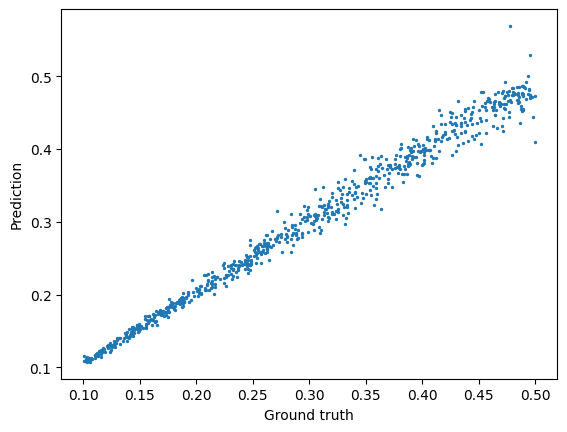

In [22]:
plt.scatter(lbl_cmd, yhat_cmd, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()

In [23]:
from adapt.parameter_based import RegularTransferNN

model_RTNN = RegularTransferNN(best_model, lambdas=1.0, random_state=0)

In [24]:
checkpoint_path_rtnn = "./cp_rtnn.ckpt"
checkpoint_dir_rtnn = os.path.dirname(checkpoint_path_rtnn)

# Create a callback that saves the model's weights
cp_callback_rtnn = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_rtnn,
                                                 save_weights_only=False,
                                                 monitor='loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

In [26]:
model_RTNN.fit(simba_train, callbacks = [cp_callback_rtnn], epochs=50);

Epoch 1/50


2022-12-21 05:21:47.449949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11 of 317
2022-12-21 05:21:57.712241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 22 of 317
2022-12-21 05:22:08.336129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 32 of 317
2022-12-21 05:22:17.770817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 44 of 317
2022-12-21 05:22:27.325064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-21 05:22:38.438799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 64 of 317
2022-12-21 05:22:47.347163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

2022-12-21 05:31:03.386746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-21 05:31:13.251051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 298 of 317
2022-12-21 05:31:23.010807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 310 of 317
2022-12-21 05:31:28.274419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2022-12-21 05:31:28.764356: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8b94007a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-21 05:31:28.764569: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-12-21 05:31:28.800463: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabl

320/320 [==============================] - ETA: 0s - loss: 78248.6016
Epoch 1: loss improved from inf to 78248.60156, saving model to ./cp_rtnn.ckpt


INFO:tensorflow:Assets written to: ./cp_rtnn.ckpt/assets


INFO:tensorflow:Assets written to: ./cp_rtnn.ckpt/assets


320/320 [==============================] - 1203s 2s/step - loss: 78248.6016
Epoch 2/50


2022-12-21 05:41:10.196595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 05:41:20.150993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 05:41:29.920799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 36 of 317
2022-12-21 05:41:39.863121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 48 of 317
2022-12-21 05:41:49.809989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-21 05:41:59.704872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 72 of 317
2022-12-21 05:42:09.591591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 157696.0781
Epoch 2: loss did not improve from 78248.60156
320/320 [==============================] - 959s 1s/step - loss: 157696.0781
Epoch 3/50


2022-12-21 05:57:09.447853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 05:57:19.322869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 05:57:28.684766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 36 of 317
2022-12-21 05:57:38.767410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 48 of 317
2022-12-21 05:57:49.297018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 05:57:59.432928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 05:58:09.401470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 169943.5312
Epoch 3: loss did not improve from 78248.60156
320/320 [==============================] - 944s 1s/step - loss: 169943.5312
Epoch 4/50


2022-12-21 06:12:53.082633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 06:13:03.198776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 26 of 317
2022-12-21 06:13:13.154741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 38 of 317
2022-12-21 06:13:22.947723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 06:13:32.817976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 06:13:42.776190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 06:13:52.770778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 174402.6094
Epoch 4: loss did not improve from 78248.60156
320/320 [==============================] - 950s 1s/step - loss: 174402.6094
Epoch 5/50


2022-12-21 06:28:42.765709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 06:28:52.642253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 06:29:02.512037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 36 of 317
2022-12-21 06:29:13.136193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 06:29:22.883545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 06:29:32.543023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 06:29:43.060434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 174626.0938
Epoch 5: loss did not improve from 78248.60156
320/320 [==============================] - 947s 1s/step - loss: 174626.0938
Epoch 6/50


2022-12-21 06:44:29.693405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 06:44:40.215131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 06:44:50.095819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 06:45:00.313202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 06:45:09.654673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-21 06:45:19.780442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 72 of 317
2022-12-21 06:45:29.956456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 180924.4844
Epoch 6: loss did not improve from 78248.60156
320/320 [==============================] - 936s 1s/step - loss: 180924.4844
Epoch 7/50


2022-12-21 07:00:05.807002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 07:00:16.445661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 07:00:26.290061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 07:00:36.040730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 07:00:46.496642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 07:00:56.422216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 07:01:06.244122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 184083.5156
Epoch 7: loss did not improve from 78248.60156
320/320 [==============================] - 941s 1s/step - loss: 184083.5156
Epoch 8/50


2022-12-21 07:15:46.745867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 07:15:56.629040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 07:16:06.562250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 36 of 317
2022-12-21 07:16:17.272126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 07:16:27.113180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 07:16:36.712421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 07:16:46.756721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 185660.1875
Epoch 8: loss did not improve from 78248.60156
320/320 [==============================] - 950s 1s/step - loss: 185660.1875
Epoch 9/50


2022-12-21 07:31:36.967537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 07:31:46.806473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 07:31:57.337618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 07:32:07.106642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 07:32:17.469821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 07:32:27.221166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 07:32:37.153025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 189475.3594
Epoch 9: loss did not improve from 78248.60156
320/320 [==============================] - 955s 1s/step - loss: 189475.3594
Epoch 10/50


2022-12-21 07:47:31.990455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 07:47:42.205494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 26 of 317
2022-12-21 07:47:52.165779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 39 of 317
2022-12-21 07:48:01.993031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 317
2022-12-21 07:48:11.670708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 63 of 317
2022-12-21 07:48:22.236491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 76 of 317
2022-12-21 07:48:31.611967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 190455.3125
Epoch 10: loss did not improve from 78248.60156
320/320 [==============================] - 955s 1s/step - loss: 190455.3125
Epoch 11/50


2022-12-21 08:03:27.102902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 08:03:36.969040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 08:03:47.281877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 08:03:56.971331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 08:04:07.606965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 08:04:17.245690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 08:04:27.227086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 195415.1094
Epoch 11: loss did not improve from 78248.60156
320/320 [==============================] - 942s 1s/step - loss: 195415.1094
Epoch 12/50


2022-12-21 08:19:10.041075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 08:19:19.736605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 08:19:29.743227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 38 of 317
2022-12-21 08:19:40.016297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 317
2022-12-21 08:19:49.665154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 63 of 317
2022-12-21 08:19:59.964748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 76 of 317
2022-12-21 08:20:10.255308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 195800.0469
Epoch 12: loss did not improve from 78248.60156
320/320 [==============================] - 938s 1s/step - loss: 195800.0469
Epoch 13/50


2022-12-21 08:34:47.612940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 08:34:57.920003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 08:35:07.657560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 08:35:17.572554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 08:35:27.728881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 08:35:37.647865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 08:35:48.128806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 194871.0938
Epoch 13: loss did not improve from 78248.60156
320/320 [==============================] - 946s 1s/step - loss: 194871.0938
Epoch 14/50


2022-12-21 08:50:33.855409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 08:50:43.765530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 08:50:53.881382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 36 of 317
2022-12-21 08:51:04.131918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 48 of 317
2022-12-21 08:51:14.126300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-21 08:51:23.903824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 72 of 317
2022-12-21 08:51:33.886478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 191503.1094
Epoch 14: loss did not improve from 78248.60156
320/320 [==============================] - 945s 1s/step - loss: 191503.1094
Epoch 15/50


2022-12-21 09:06:19.233587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 09:06:29.829196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 09:06:39.209301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 09:06:49.825548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 09:06:59.534776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 09:07:09.649267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 75 of 317
2022-12-21 09:07:19.389714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 193473.9844
Epoch 15: loss did not improve from 78248.60156
320/320 [==============================] - 940s 1s/step - loss: 193473.9844
Epoch 16/50


2022-12-21 09:21:59.234398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 09:22:09.727233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 09:22:19.614187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 09:22:29.575575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 09:22:39.320725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 09:22:49.166250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 09:22:59.503676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 188272.7656
Epoch 16: loss did not improve from 78248.60156
320/320 [==============================] - 943s 1s/step - loss: 188272.7656
Epoch 17/50


2022-12-21 09:37:42.514882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 09:37:52.361185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 09:38:02.987302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 09:38:13.024700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 09:38:22.282623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-21 09:38:32.823260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 09:38:42.843031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 189740.7344
Epoch 17: loss did not improve from 78248.60156
320/320 [==============================] - 950s 1s/step - loss: 189740.7344
Epoch 18/50


2022-12-21 09:53:32.675050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 09:53:42.218356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 26 of 317
2022-12-21 09:53:52.906931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 42 of 317
2022-12-21 09:54:02.386727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-21 09:54:12.372556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 67 of 317
2022-12-21 09:54:22.556940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 79 of 317
2022-12-21 09:54:32.572689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 191043.8125
Epoch 18: loss did not improve from 78248.60156
320/320 [==============================] - 934s 1s/step - loss: 191043.8125
Epoch 19/50


2022-12-21 10:09:06.665180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 10:09:16.851346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 10:09:26.684810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 10:09:36.433914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 10:09:46.265271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 10:09:56.846473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 10:10:06.703202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 186568.7344
Epoch 19: loss did not improve from 78248.60156
320/320 [==============================] - 942s 1s/step - loss: 186568.7344
Epoch 20/50


2022-12-21 10:24:48.690184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 10:24:58.442522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 10:25:08.259559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 10:25:18.460673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 10:25:28.315993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 10:25:38.220259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 10:25:48.062111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 190725.4688
Epoch 20: loss did not improve from 78248.60156
320/320 [==============================] - 943s 1s/step - loss: 190725.4688
Epoch 21/50


2022-12-21 10:40:31.456887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 10:40:42.091643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 26 of 317
2022-12-21 10:40:51.997178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 38 of 317
2022-12-21 10:41:01.593997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 10:41:11.935071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 76 of 317
2022-12-21 10:41:21.839451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 88 of 317
2022-12-21 10:41:31.890842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 191952.0312
Epoch 21: loss did not improve from 78248.60156
320/320 [==============================] - 929s 1s/step - loss: 191952.0312
Epoch 22/50


2022-12-21 10:56:00.431228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 10:56:10.488585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 10:56:20.361887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 36 of 317
2022-12-21 10:56:30.975426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 10:56:41.014727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 10:56:50.847562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 10:57:00.685498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 191053.9375
Epoch 22: loss did not improve from 78248.60156
320/320 [==============================] - 939s 1s/step - loss: 191053.9375
Epoch 23/50


2022-12-21 11:11:39.441944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 11:11:49.288726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 11:11:59.159572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 36 of 317
2022-12-21 11:12:09.682711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 11:12:19.598192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 11:12:29.600100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 11:12:39.549824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 195319.3125
Epoch 23: loss did not improve from 78248.60156
320/320 [==============================] - 937s 1s/step - loss: 195319.3125
Epoch 24/50


2022-12-21 11:27:16.165117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 11:27:26.740993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 26 of 317
2022-12-21 11:27:36.097870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 38 of 317
2022-12-21 11:27:46.794495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 317
2022-12-21 11:27:56.679531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 63 of 317
2022-12-21 11:28:06.845918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 75 of 317
2022-12-21 11:28:16.237594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 194168.1250
Epoch 24: loss did not improve from 78248.60156
320/320 [==============================] - 949s 1s/step - loss: 194168.1250
Epoch 25/50


2022-12-21 11:43:05.738976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 11:43:15.686449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 11:43:26.168355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 11:43:36.056756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 11:43:45.935061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 11:43:55.841869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 11:44:06.437657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 194471.6094
Epoch 25: loss did not improve from 78248.60156
320/320 [==============================] - 937s 1s/step - loss: 194471.6094
Epoch 26/50


2022-12-21 11:58:42.961975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 14 of 317
2022-12-21 11:58:52.859084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 26 of 317
2022-12-21 11:59:03.134306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 39 of 317
2022-12-21 11:59:13.200448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 52 of 317
2022-12-21 11:59:22.750032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 64 of 317
2022-12-21 11:59:33.003633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 77 of 317
2022-12-21 11:59:42.588216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 193645.8438
Epoch 26: loss did not improve from 78248.60156
320/320 [==============================] - 945s 1s/step - loss: 193645.8438
Epoch 27/50


2022-12-21 12:14:27.905488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 12:14:37.709327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 12:14:48.170267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 12:14:57.944054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 12:15:07.689017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 12:15:18.108537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 12:15:28.022520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 189691.6562
Epoch 27: loss did not improve from 78248.60156
320/320 [==============================] - 947s 1s/step - loss: 189691.6562
Epoch 28/50


2022-12-21 12:30:15.438535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 14 of 317
2022-12-21 12:30:25.556142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 30 of 317
2022-12-21 12:30:35.491980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 42 of 317
2022-12-21 12:30:45.501851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-21 12:30:55.705978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 66 of 317
2022-12-21 12:31:05.732702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 78 of 317
2022-12-21 12:31:15.552069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 190867.2656
Epoch 28: loss did not improve from 78248.60156
320/320 [==============================] - 951s 1s/step - loss: 190867.2656
Epoch 29/50


2022-12-21 12:46:07.175562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 12:46:16.887828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 12:46:27.595191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 39 of 317
2022-12-21 12:46:37.495467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 317
2022-12-21 12:46:47.128792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 63 of 317
2022-12-21 12:46:56.939642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 75 of 317
2022-12-21 12:47:07.152030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 191074.1875
Epoch 29: loss did not improve from 78248.60156
320/320 [==============================] - 948s 1s/step - loss: 191074.1875
Epoch 30/50


2022-12-21 13:01:56.221045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 317
2022-12-21 13:02:06.006207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 27 of 317
2022-12-21 13:02:16.019699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 39 of 317
2022-12-21 13:02:26.188535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 317
2022-12-21 13:02:36.313255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 63 of 317
2022-12-21 13:02:45.519605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 13:02:55.624672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 194928.6250
Epoch 30: loss did not improve from 78248.60156
320/320 [==============================] - 921s 1s/step - loss: 194928.6250
Epoch 31/50


2022-12-21 13:17:16.968566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 13:17:27.618003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 13:17:37.120258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 13:17:47.611533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 13:17:57.486052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 13:18:07.375784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 13:18:16.942378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 195453.2344
Epoch 31: loss did not improve from 78248.60156
320/320 [==============================] - 933s 1s/step - loss: 195453.2344
Epoch 32/50


2022-12-21 13:32:50.260579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 317
2022-12-21 13:33:00.150237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 29 of 317
2022-12-21 13:33:10.300255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 44 of 317
2022-12-21 13:33:20.268198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-21 13:33:30.257935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 68 of 317
2022-12-21 13:33:40.047608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 80 of 317
2022-12-21 13:33:50.181468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 187487.3594
Epoch 32: loss did not improve from 78248.60156
320/320 [==============================] - 937s 1s/step - loss: 187487.3594
Epoch 33/50


2022-12-21 13:48:27.909520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 13:48:37.279781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 13:48:47.653682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 38 of 317
2022-12-21 13:48:57.416806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 13:49:07.537001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 13:49:17.670909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 13:49:27.703810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 186607.3438
Epoch 33: loss did not improve from 78248.60156
320/320 [==============================] - 950s 1s/step - loss: 186607.3438
Epoch 34/50


2022-12-21 14:04:17.334401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 14:04:27.781214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 14:04:37.293925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 14:04:47.654929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 14:04:57.395859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 14:05:07.202872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 14:05:17.768249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 182167.3281
Epoch 34: loss did not improve from 78248.60156
320/320 [==============================] - 946s 1s/step - loss: 182167.3281
Epoch 35/50


2022-12-21 14:20:02.948293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 14:20:13.309058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 14:20:23.127828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 14:20:33.646978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 14:20:43.209902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 14:20:53.107436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 14:21:03.049778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 183449.9375
Epoch 35: loss did not improve from 78248.60156
320/320 [==============================] - 929s 1s/step - loss: 183449.9375
Epoch 36/50


2022-12-21 14:35:31.995446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 14:35:42.192677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 14:35:52.028618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 14:36:01.958748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 14:36:11.753950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 14:36:22.204996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 14:36:32.210703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 184670.6719
Epoch 36: loss did not improve from 78248.60156
320/320 [==============================] - 951s 1s/step - loss: 184670.6719
Epoch 37/50


2022-12-21 14:51:23.209948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 14:51:33.258404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 26 of 317
2022-12-21 14:51:42.986575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 38 of 317
2022-12-21 14:51:52.981702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 14:52:03.155605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 14:52:13.247437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 14:52:23.199599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 185214.6406
Epoch 37: loss did not improve from 78248.60156
320/320 [==============================] - 943s 1s/step - loss: 185214.6406
Epoch 38/50


2022-12-21 15:07:05.601220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 15:07:16.121672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 15:07:26.048110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 15:07:35.758413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 15:07:45.656709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 15:07:55.730610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 15:08:05.720774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 184075.4688
Epoch 38: loss did not improve from 78248.60156
320/320 [==============================] - 950s 1s/step - loss: 184075.4688
Epoch 39/50


2022-12-21 15:22:56.330192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 14 of 317
2022-12-21 15:23:06.132790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 27 of 317
2022-12-21 15:23:16.255294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 39 of 317
2022-12-21 15:23:26.267671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 317
2022-12-21 15:23:36.763299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 64 of 317
2022-12-21 15:23:46.673229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 76 of 317
2022-12-21 15:23:56.469994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 184536.7188
Epoch 39: loss did not improve from 78248.60156
320/320 [==============================] - 947s 1s/step - loss: 184536.7188
Epoch 40/50


2022-12-21 15:38:43.916084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 15:38:53.734930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 15:39:04.167645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 15:39:14.409354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 15:39:24.436416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 15:39:34.044086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 15:39:44.434435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 183784.5000
Epoch 40: loss did not improve from 78248.60156
320/320 [==============================] - 947s 1s/step - loss: 183784.5000
Epoch 41/50


2022-12-21 15:54:31.268978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 15:54:41.784887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 15:54:51.717692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 15:55:01.789509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 15:55:12.001184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 15:55:21.287372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 72 of 317
2022-12-21 15:55:31.934182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 184944.6406
Epoch 41: loss did not improve from 78248.60156
320/320 [==============================] - 939s 1s/step - loss: 184944.6406
Epoch 42/50


2022-12-21 16:10:10.765524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 16:10:20.961376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 27 of 317
2022-12-21 16:10:30.762354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 47 of 317
2022-12-21 16:10:40.722274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 16:10:50.574140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 94 of 317
2022-12-21 16:11:00.860686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 106 of 317
2022-12-21 16:11:10.813773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this

320/320 [==============================] - ETA: 0s - loss: 190427.1875
Epoch 42: loss did not improve from 78248.60156
320/320 [==============================] - 924s 1s/step - loss: 190427.1875
Epoch 43/50


2022-12-21 16:25:35.197074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 16:25:45.465932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 16:25:55.542012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 38 of 317
2022-12-21 16:26:05.709354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 52 of 317
2022-12-21 16:26:15.618940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 64 of 317
2022-12-21 16:26:25.601217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 76 of 317
2022-12-21 16:26:35.667121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 187470.0625
Epoch 43: loss did not improve from 78248.60156
320/320 [==============================] - 935s 1s/step - loss: 187470.0625
Epoch 44/50


2022-12-21 16:41:10.704320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 16:41:21.245289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 16:41:30.913329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 16:41:40.771401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 16:41:50.803124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 16:42:00.992800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 16:42:11.116749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 188077.7812
Epoch 44: loss did not improve from 78248.60156
320/320 [==============================] - 948s 1s/step - loss: 188077.7812
Epoch 45/50


2022-12-21 16:56:59.839515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 16:57:09.833599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 16:57:20.090355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 16:57:29.945961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 16:57:39.294207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-21 16:57:49.514095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 72 of 317
2022-12-21 16:57:59.390353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 194659.6250
Epoch 45: loss did not improve from 78248.60156
320/320 [==============================] - 938s 1s/step - loss: 194659.6250
Epoch 46/50


2022-12-21 17:12:37.325453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 17:12:47.092398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 17:12:57.501588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 17:13:07.442622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 17:13:17.671041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 17:13:27.260875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 17:13:37.103453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 186096.8281
Epoch 46: loss did not improve from 78248.60156
320/320 [==============================] - 939s 1s/step - loss: 186096.8281
Epoch 47/50


2022-12-21 17:28:16.283418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 17:28:26.266187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 17:28:36.725183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 17:28:46.174851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 317
2022-12-21 17:28:56.063023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 63 of 317
2022-12-21 17:29:05.982062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 75 of 317
2022-12-21 17:29:15.959013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 190375.0312
Epoch 47: loss did not improve from 78248.60156
320/320 [==============================] - 950s 1s/step - loss: 190375.0312
Epoch 48/50


2022-12-21 17:44:06.446764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 17:44:16.099652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 17:44:25.932408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 38 of 317
2022-12-21 17:44:36.135729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 317
2022-12-21 17:44:46.349552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 64 of 317
2022-12-21 17:44:56.383091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 77 of 317
2022-12-21 17:45:05.902807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 190854.2656
Epoch 48: loss did not improve from 78248.60156
320/320 [==============================] - 948s 1s/step - loss: 190854.2656
Epoch 49/50


2022-12-21 17:59:54.784627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 317
2022-12-21 18:00:04.780715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 317
2022-12-21 18:00:14.362837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-21 18:00:24.222211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 18:00:34.877066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-21 18:00:44.773920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-21 18:00:54.646248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 189581.8750
Epoch 49: loss did not improve from 78248.60156
320/320 [==============================] - 949s 1s/step - loss: 189581.8750
Epoch 50/50


2022-12-21 18:15:43.364603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 317
2022-12-21 18:15:53.171331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 24 of 317
2022-12-21 18:16:03.130402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 36 of 317
2022-12-21 18:16:13.885247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-21 18:16:23.560982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-21 18:16:33.401405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 317
2022-12-21 18:16:43.160975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

320/320 [==============================] - ETA: 0s - loss: 183911.7812
Epoch 50: loss did not improve from 78248.60156
320/320 [==============================] - 932s 1s/step - loss: 183911.7812


In [27]:
best_model_rtnn = tf.keras.models.load_model(checkpoint_path_rtnn)

In [29]:
yhat_cmd_2 = best_model_rtnn.predict(cmd_test)
yhat_simba_2 = best_model_rtnn.predict(simba_test)

6/6 [==============================] - 1s 55ms/step


In [30]:
np.mean(np.abs((lbl_cmd - yhat_cmd_2) / lbl_cmd))

0.25728282

In [31]:
np.mean(np.abs((lbl_simba - yhat_simba_2) / lbl_simba))

0.41446012